In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
import os, copy
import time

import util_functions as fs
import symbol_path as pth
import imp
imp.reload(fs)
imp.reload(pth)

%matplotlib inline

In [2]:
#Read music sheets - Binary thresholding and resizing
sheets = fs.get_images('./data/test_sheets', resize_factor=1, threshold=200)

>>> Folder : ./data/test_sheets : 14 files
01 : ./data/test_sheets/Sample01.jpg : (1657, 1177)
02 : ./data/test_sheets/Sample02.jpg : (1353, 1174)
03 : ./data/test_sheets/fire.jpg : (3508, 2479)
04 : ./data/test_sheets/hush.jpg : (1100, 850)
05 : ./data/test_sheets/kookaburra.jpg : (1453, 2453)
06 : ./data/test_sheets/mary.jpg : (1288, 2456)
07 : ./data/test_sheets/p1 (1).jpg : (2339, 1653)
08 : ./data/test_sheets/p1.jpg : (2339, 1653)
09 : ./data/test_sheets/p1.png : (1809, 1280)
10 : ./data/test_sheets/p2 (1).jpg : (2339, 1653)
11 : ./data/test_sheets/p2.jpg : (2339, 1653)
12 : ./data/test_sheets/p2.png : (1809, 1280)
13 : ./data/test_sheets/races.jpg : (1600, 1465)
14 : ./data/test_sheets/teapot.jpg : (1101, 851)
>>> Inverse binary thresholding with threshold value 200


In [3]:
#Pick Sample page
sample_image = sheets[8]

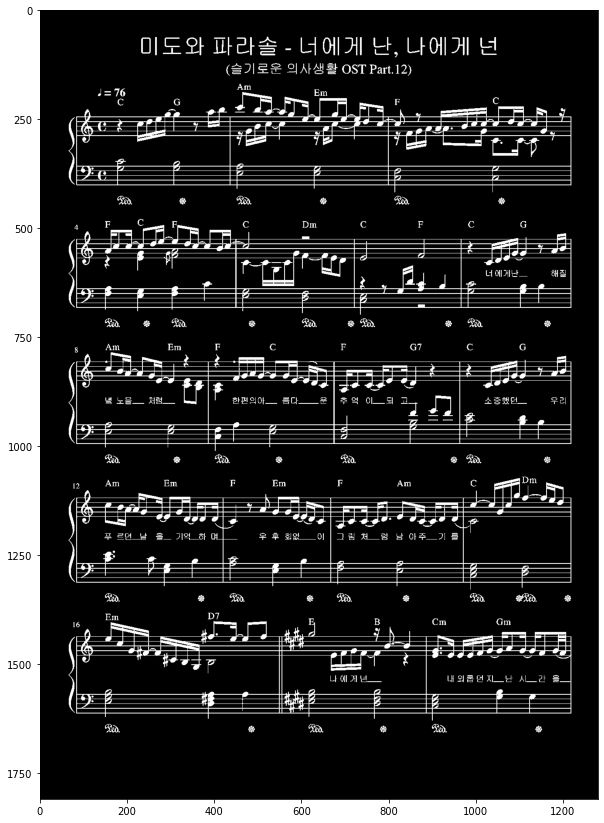

In [4]:
#Show sample
fs.plot_single_image(sample_image, off_axis=False)

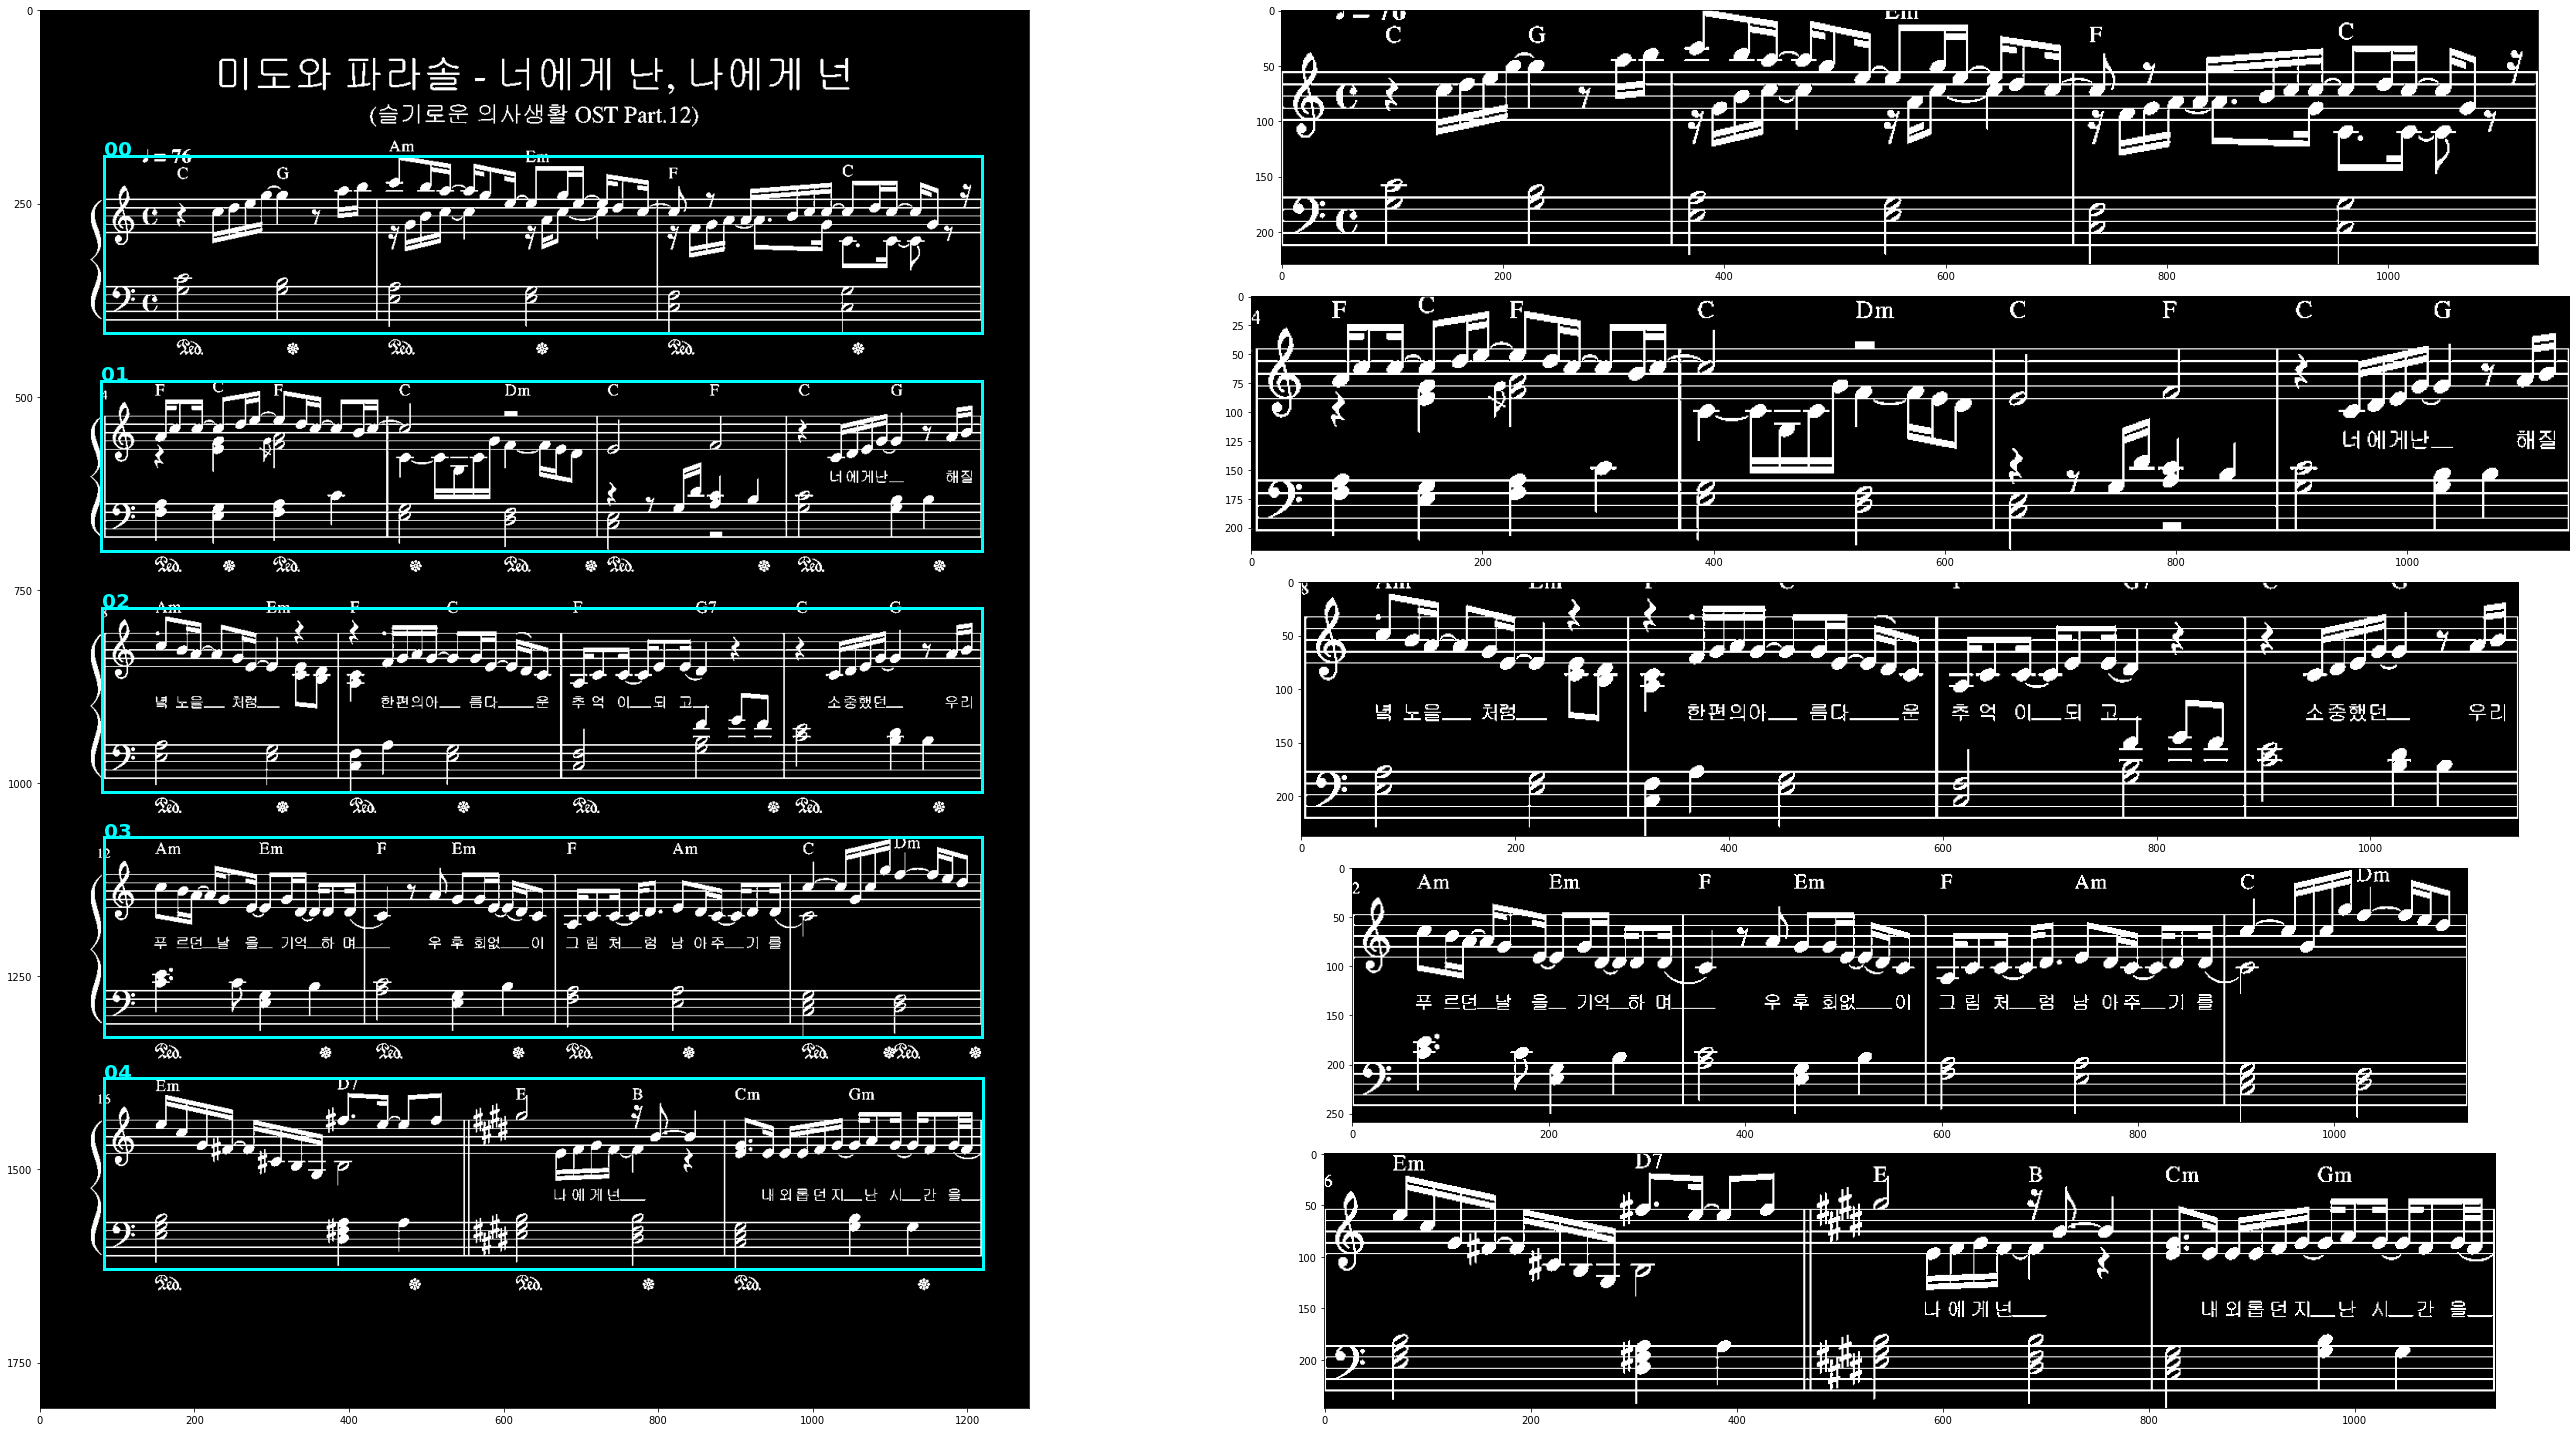

In [5]:
#Extract main components of sheet
main_components, pos, _ = fs.get_main_components(sample_image)
#Rearrange position of main components
main_components, pos = fs.arrange_components_idx(main_components, pos)

#Show show components
fig = plt.figure(figsize=(40,20))
ax = plt.subplot2grid((len(main_components), 2), (0, 0), rowspan=len(main_components))
ax.imshow(sample_image, cmap='gray')

for i, (x, y, w, h, area) in enumerate(pos):  #Highlighting
    ax.add_patch(patches.Rectangle((x, y), w, h, edgecolor='cyan', fill=False, linewidth=3))
    ax.text(x, y, f'{i:02d}', color='cyan', fontsize=20, fontweight='bold')

for i in range(len(main_components)):  #Show only component
    ax = plt.subplot2grid((len(main_components), 2), (i, 1))
    ax.imshow(main_components[i], cmap='gray')

fig.set_tight_layout(True)
plt.show() 

In [6]:
print('Extractable Object List')
print(*[k for k in pth.template.keys()], sep=' && ')

Extractable Object List
treble && bass && sharp && flat && quarter_note && half_note && whole_note && eighth_rest && quarter_rest && half_rest && whole_rest && barline && time


In [7]:
#Classifying symbols
cleves = ['treble', 'bass']
notes = ['quarter_note', 'half_note', 'whole_note']
rests = ['eighth_rest', 'quarter_rest', 'half_rest', 'whole_rest']

def show_symbols_all(name_list):
    tlist = []
    for tname in name_list:
        tlist.extend(pth.template[tname])

    fig = plt.figure(figsize=(10,3))
    for i, t in enumerate(tlist):
        ax = fig.add_subplot(1, len(tlist), i+1)
        ax.imshow(t, cmap='gray')
    plt.show()
    return tlist

Cleves


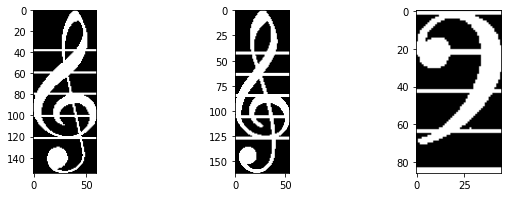

In [8]:
#show symbols - cleves
print('Cleves')
_ = show_symbols_all(cleves)

In [ ]:
#show symbols - notes
print('Notes head')
note_templates = show_symbols_all(notes)

>>Component : 0
Treble :: pos : (x, y) = (11, 36), shape : (w, h)= (27, 81), best scale : 0.5, best score : 0.74
Bass :: pos : (x, y) = (10, 168), shape : (w, h)= (24, 46), best scale : 0.53, best score : 0.67
>>Component : 1
Treble :: pos : (x, y) = (15, 25), shape : (w, h)= (27, 81), best scale : 0.5, best score : 0.74
Bass :: pos : (x, y) = (15, 160), shape : (w, h)= (22, 43), best scale : 0.5, best score : 0.65
>>Component : 2
Treble :: pos : (x, y) = (14, 12), shape : (w, h)= (27, 81), best scale : 0.5, best score : 0.72
Bass :: pos : (x, y) = (14, 178), shape : (w, h)= (22, 43), best scale : 0.5, best score : 0.66
>>Component : 3
Treble :: pos : (x, y) = (11, 27), shape : (w, h)= (27, 81), best scale : 0.5, best score : 0.72
Bass :: pos : (x, y) = (11, 199), shape : (w, h)= (22, 43), best scale : 0.5, best score : 0.63
>>Component : 4
Treble :: pos : (x, y) = (11, 34), shape : (w, h)= (27, 81), best scale : 0.5, best score : 0.70
Bass :: pos : (x, y) = (10, 185), shape : (w, h)= 

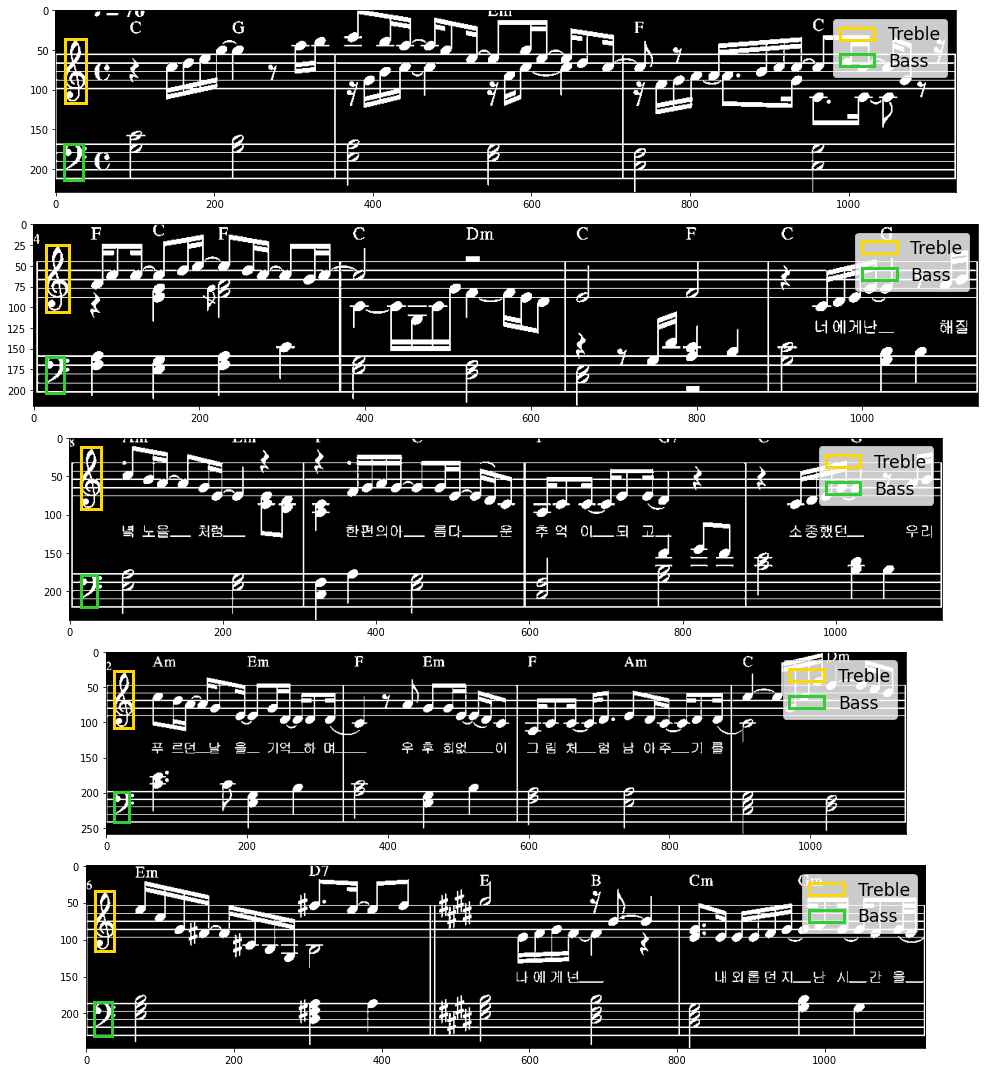

In [9]:
ts = time.time()

fig = plt.figure(figsize=(30,15))
for i, component in enumerate(main_components):        
    ax = plt.subplot2grid((len(main_components), 2), (i, 0))
    ax.imshow(main_components[i], cmap='gray')
    
    #Find clef - treble
    score_t, scale_t, idx_t, shape_t, template_t = fs.find_best_match(component, pth.template["treble"], np.arange(0.5, 0.9, 0.03), search_area_ratio=3)
    ax.add_patch(patches.Rectangle(idx_t[::-1], *shape_t[::-1], edgecolor='gold', fill=False, linewidth=3, label='Treble'))
    
    #Find clef - bass
    score_b, scale_b, idx_b, shape_b, template_b = fs.find_best_match(component, pth.template["bass"], np.arange(0.5, 0.9, 0.03), search_area_ratio=3)
    ax.add_patch(patches.Rectangle(idx_b[::-1], *shape_b[::-1], edgecolor='limegreen', fill=False, linewidth=3, label='Bass'))
    
    #Find Notes
    match_infos = fs.find_high_matches(component, note_imgs, np.arange(max(0.2, scale_t-0.25), scale_t+0.25, 0.03)[::-1], 0.65)

    
    
    
    ax.legend(loc='upper right', fontsize='xx-large')
    
    print(f'>>Component : {i}')
    print(f'Treble :: pos : (x, y) = {idx_t[::-1]}, shape : (w, h)= {shape_t[::-1]}, best scale : {scale_t}, best score : {score_t:.2f}')
    print(f'Bass :: pos : (x, y) = {idx_b[::-1]}, shape : (w, h)= {shape_b[::-1]}, best scale : {scale_b}, best score : {score_b:.2f}')

tf = time.time()
print(f'>>Runtime : {tf-ts:.2f} sec')

fig.set_tight_layout(True)
plt.show() 

Notes head


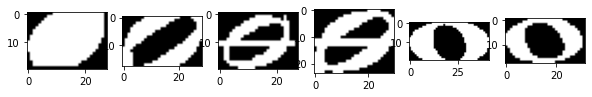

In [11]:
sample_component = main_components[0]

ts = time.time()

fig = plt.figure(figsize=(30,15))
_, scale, clef_idx, clef_shape, _ = fs.find_best_match(sample_component, pth.clef_imgs["treble"], np.arange(0.4, 0.9, 0.03), search_area_ratio=3)
match_infos = fs.find_high_matches(sample_component, note_imgs, np.arange(max(0.2, scale-0.25), scale+0.25, 0.03)[::-1], 0.65)
        
ax = fig.add_subplot(1, 1, 1)
ax.imshow(sample_component, cmap='gray')
ax.add_patch(patches.Rectangle(clef_idx[::-1], *clef_shape[::-1], edgecolor='pink', fill=False, linewidth=3, label='Clef'))

for j, info in enumerate(match_infos):
    ax.add_patch(patches.Rectangle((0,0), 0, 0, edgecolor=color_list[j], fill=False, label=f"T{j}:{info['num']}"))
    
    if info['num'] == 0: 
        continue
    for k in range(info['num']):
        ax.add_patch(patches.Rectangle((info['location'][1][k], info['location'][0][k]), *info['shape'][::-1],  edgecolor=color_list[j], fill=False))

ax.set_anchor('W')
ax.legend(fontsize='large', loc='lower right')

fig.set_tight_layout(True)
plt.show() 

tf = time.time()
print(f'Runtime : {tf-ts:.2f} sec')

AttributeError: module 'symbol_path' has no attribute 'clef_imgs'

<Figure size 2160x1080 with 0 Axes>